In [1]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np
from point import Point

Same pool of trials for all participants (static), with different shuffling (dynamic).

---

# Static Layout Pool
This refers to the generation of the layout pool, which will is the same for ALL participants.

## Generation

- Given N trials, we produce  N/2 pairs of layouts.
    - Between these pairs, we keep the same coordinates for the points, and the same order of navigation.
    - One of these pairs is the no-boundary-show, the other is the boundary-shown. The layout is rotated between these two.
    - Per layout, we have 5 objects and an ending location. The first object is also the starting location and might be asked.
    - We do not want any 2 objects to be too close to each other.
    - We do not want any path to be too short. We do not have an upper bound on the travel distance.
    - We want to to make sure that there is at least one object on both sides.

In [2]:
N_POINTS_LAYOUT = 6 # 5 objects, one of which is the starting location, and an ending location
N_LAYOUTS = 50 # generate this many layouts. each layout produces a pair (visible/invisible boundary)

# these are currently arbitrary units that we can scale up and down as needed
# w=5, l=10 represents a 1 by 2 rectangle room
WIDTH = 5 
LENGTH = 10

# this is the minimum distance any two objects (not a path) can have. 
# used to prevent objects appearing too close and confusing participants
MIN_DIST_OBJECTS = 1.5

# this is the minimum path distance. no subsequent object should appear closer than this.
# greater than MIN_DIST_OBJECTS because objects appearing too close also means they are visited too soon and not enough time to learn that object
MIN_DIST_PATH = 2.3

In [3]:
def generate_random_layout():
    return [Point.random_rect(WIDTH, LENGTH) for p in range(N_POINTS_LAYOUT)]

def is_valid_layout(lay):
    
    # check all distance constraints, (dist between objects and path distances)
    for i in range(len(lay)):
        for j in range(i):
            # if these points are adjacent, check for path distance condition, otherwise object distance condition
            lower_bound = MIN_DIST_PATH if j == i - 1 else MIN_DIST_OBJECTS
            if lay[i].dist(lay[j]) <= lower_bound:
                return False
    
    # check that there is at least one object on each side
    # note that this checks for objects ONLY (that is; not the last point which is the ending/task location)
    objects_on_lower_side = sum([1 if l.y < LENGTH / 2 else 0 for l in lay[:N_POINTS_LAYOUT-1]])
    if not ( 1 <= objects_on_lower_side < N_POINTS_LAYOUT-1):
        # either 0 or N_POINTS_LAYOUT-1 on this side, which means the reverse for the other side. not valid!
        return False
            
    return True

def generate_valid_layout():
    candidate = generate_random_layout()
    c = 0
    while not is_valid_layout(candidate):
        c += 1
        if c == 1e5:
            print("can not find valid layout!")
            return None
        candidate = generate_random_layout()
    return candidate

In [4]:
layouts = []
for l in range(N_LAYOUTS):
    layouts.append(generate_valid_layout())

In [5]:
print(layouts)

[[P(2.03, 8.34), P(4.73, 2.85), P(1.09, 2.13), P(3.73, 6.91), P(0.24, 9.47), P(3.83, 8.62)], [P(4.35, 9.13), P(2.47, 4.13), P(4.66, 5.12), P(4.54, 0.86), P(0.35, 5.2), P(3.35, 2.18)], [P(2.76, 10.0), P(0.33, 6.17), P(0.33, 0.93), P(2.74, 4.07), P(3.63, 1.66), P(4.84, 5.3)], [P(0.13, 1.09), P(1.39, 7.14), P(3.09, 9.13), P(0.04, 6.0), P(4.52, 6.62), P(2.36, 2.63)], [P(1.21, 1.36), P(3.8, 4.59), P(3.15, 9.76), P(1.46, 6.24), P(4.17, 0.86), P(2.06, 4.11)], [P(0.41, 9.16), P(3.93, 0.79), P(0.86, 7.43), P(1.51, 1.31), P(2.33, 9.75), P(0.17, 4.69)], [P(0.56, 3.07), P(4.7, 3.19), P(4.76, 6.0), P(3.86, 9.22), P(0.39, 8.59), P(1.79, 1.29)], [P(0.2, 9.32), P(3.73, 9.73), P(0.48, 6.76), P(0.29, 0.31), P(3.09, 0.63), P(1.36, 4.84)], [P(1.26, 9.97), P(3.85, 4.73), P(1.3, 2.87), P(3.18, 0.87), P(0.99, 5.16), P(3.46, 6.78)], [P(0.15, 4.14), P(2.6, 7.38), P(4.49, 9.97), P(1.11, 2.5), P(0.1, 7.84), P(4.38, 4.89)], [P(2.89, 4.13), P(2.9, 7.12), P(2.75, 0.09), P(0.34, 9.35), P(1.05, 6.24), P(1.2, 1.96)], 

## Checks
- We want to check for the following distributions:
    - Pointing ground-truths -> compare those in the same side and across the boundary.
    - How much they have traveled
    - Distances between any two objects

In [25]:
# Ground Truth for Pointing Tasks (GTPT)
gtpt_same = []
gtpt_cross = []

for lay in layouts:
    last = lay[-1]
    last_side = last.y < LENGTH / 2
    
    for obj in lay[:-1]:
        is_on_same_side = last_side == (obj.y < LENGTH / 2)
        dist = last.dist(obj)
        if is_on_same_side:
            gtpt_same.append(dist)
        else:
            gtpt_cross.append(dist)

gtpt_all = [gtpt_same, gtpt_cross]
print(len(gtpt_same), "same side; ", len(gtpt_cross), "across boundary")

117 same side;  133 across boundary


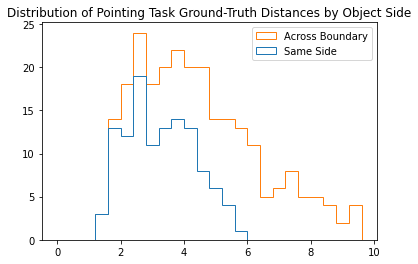

In [36]:
plt.hist(gtpt_all, bins = 24, range = [0, max(gtpt_same + gtpt_cross)] ,histtype='step', stacked=True, fill=False, label = ["Same Side", "Across Boundary"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Pointing Task Ground-Truth Distances by Object Side")
plt.show()

# Dynamic Trial Shuffling
- We shuffle the N trials such that the boundary visibility alternates each time.

## Checks

- At least K = 5 trials between trials of the same pairing.
- We make sure that approx. half the pairs happen in A->B, and the other half happens in B->A
- We make sure that between adjacent pairs, the ending location and starting location is always opposite.
- We want to check the number of objects within the same cells across a sliding window of 5 trials.

# Objects
- 5 different shapes (circle, cube, cylinder, pyramid, star)
- 5 different colors from a color-blind-friendly palette.
-> 25 different combinations.

Any object generated must not have been in the last 10 shown object.